# Credit Card Fraud - Prevention through Data Science
__Team 3 - Brianne Bell, Michael Nguyen, and Dave Friesen__<br>
__ADS-505-02-FA22__<br><br>
__GitHub link: https://github.com/davefriesen/cc-fraud-prevention__

In [1]:
__authors__ = ['Brianne Bell', 'Michael Nguyen', 'Dave Friesen']
__contact__ = ['bbell@sandiego.edu', 'michaelnguyen@sandiego.edu', 'dfriesen@sandiego.edu']
__date__ = '2022-10-17'
__license__ = 'MIT'
__version__ = '1.0.0'

# Setup

In [50]:
# Set working directory for 'custom' (profiler, model_process) .py find and data access
#   UNIQUE TO COLLABORATOR
import os, sys

#src_dir = 'C:/Users/breel.B-E-BELL/OneDrive/Documents/USD_MastersAppliedDataScience/ADS-505 ADSforBusiness/Final Project Files'
#data_dir = 'C:/Users/breel.B-E-BELL/OneDrive/Documents/USD_MastersAppliedDataScience/ADS-505 ADSforBusiness/Final Project Files/'

src_dir = '/Users/davidfriesen/Desktop/OneDrive/projects/cc-fraud-protection/src'
data_dir = '/Users/davidfriesen/Desktop/OneDrive/projects/cc-fraud-protection/data/'

sys.path.append(src_dir)
os.chdir(data_dir)

In [55]:
# Import basic libraries
import numpy as np
import pandas as pd

# Import visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
from dmba import gainsChart

# Import custom EDA library
from profiler import profile, profile_cat

# Import model and performance evaluation libraries
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.neural_network import MLPClassifier

# Import custom model library
from model_process import ModelProcess

# Import utility libraries
import copy
from utils import ctrl_count

In [56]:
# Set basic np, pd, and plt output defaults (keeping this code 'clean')
%run -i '{src_dir}/defaults.py'

### Set simple notebook style and auto-avoid scrollable output windows

In [5]:
%%html
<style>
    h1, h2 {font-size: 0.9em; color: #0070c0;}
    h1, h2, h3 {line-height: 1.2em !important; margin-top: 2em !important;}
    h4, p {font-size: 1.2em !important; line-height: 1.2em !important;}
</style>

In [6]:
%%javascript
    IPython.OutputArea.prototype._should_scroll = function(lines) {
        return false;
    }

<IPython.core.display.Javascript object>

# Data Load and Validation

__Fraud e-commerce: 'Fraud_Data' and 'IpAddress_to_Country'__

In [7]:
# Ref: https://www.kaggle.com/datasets/vbinh002/fraud-ecommerce?resource=download

# Create and confirm fraud dataframe
fraud_fname = data_dir + 'c-Fraud_Data.csv'
fraud_ctrl = ctrl_count(fraud_fname)
fraud_df = pd.read_csv(fraud_fname, on_bad_lines = 'skip', low_memory = False)

print('\nFraud: file=%0d, import=%0d, delta=%0d' %
      (fraud_ctrl, len(fraud_df), fraud_ctrl - len(fraud_df)))
print('\nFraud rows, columns: ', fraud_df.shape)
print('\nFraud dataframe:'); __ = fraud_df.info()
print('\nFraud data:\n', fraud_df.head(5))

# Dataframe comparision e.g., if have sep training/test sets - n/a here
#print('\nSame? ', np.array_equal(fundr_df.columns, ffundr_df.columns))


Fraud: file=151113, import=151112, delta=1

Fraud rows, columns:  (151112, 11)

Fraud dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB

Fraud data:
    user_id     signup_time         purchase_time      purchase_value   device_id    source browser sex  age   ip_add

In [8]:
# Ref: https://www.kaggle.com/datasets/vbinh002/fraud-ecommerce?resource=download

# Create and confirm IP dataframe
ip_fname = data_dir + 'c-IpAddress_to_Country.csv'
ip_ctrl = ctrl_count(ip_fname)
ip_df = pd.read_csv(ip_fname, on_bad_lines = 'skip', low_memory = False)

print('\n\nIP: file=%0d, import=%0d, delta=%0d' %
      (ip_ctrl, len(ip_df), ip_ctrl - len(ip_df)))
print('\nIP rows, columns: ', ip_df.shape)
print('\nIP dataframe:'); __ = ip_df.info()
print('\nIP data:\n', ip_df.head(5))



IP: file=138847, import=138846, delta=1

IP rows, columns:  (138846, 3)

IP dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB

IP data:
    lower_bound_ip_address  upper_bound_ip_address  country  
0       16777216.00               16777471         Australia
1       16777472.00               16777727             China
2       16777728.00               16778239             China
3       16778240.00               16779263         Australia
4       16779264.00               16781311             China


# Data Profiling

In [9]:
# Profile base dataframe(s)
profile(fraud_df)
profile(ip_df)

,Dtype,count,unique,na,na%,mean,std,min,max,skew(>=3),<v0.01,VIF(>=10),examples
user_id,int64,151112,151112,,,200171.0,115369.3,2.0,400000.0,,,,105713__363927__1658
signup_time,object,151112,151112,,,,,,,,,,2015-01-09 12:48:27_
purchase_time,object,151112,150679,,,,,,,,,,2015-01-09 12:48:28_
purchase_value,int64,151112,122,,,36.9,18.3,9.0,154.0,,,,45__49__45__23__27
device_id,object,151112,137956,,,,,,,,,,VEQOQPGGZUCWY__FBSLP
source,object,151112,3,,,,,,,,,,Direct__Ads__Ads__SE
browser,object,151112,5,,,,,,,,,,Chrome__FireFox__Fir
sex,object,151112,2,,,,,,,,,,F__M__M__F__F
age,int64,151112,58,,,33.1,8.6,18.0,76.0,,,,27__23__22__38__23
ip_address,float64,151112,143512,,,2152145331.0,1248497030.1,52093.5,4294850499.7,,,,3224982087.21511__65


,Dtype,count,unique,na,na%,mean,std,min,max,skew(>=3),<v0.01,VIF(>=10),examples
lower_bound_ip_address,float64,138846,138846,,,2724531562.5,897521519.7,16777216.0,3758096128.0,,,87217586.8,3399036928.0__261160
upper_bound_ip_address,int64,138846,138846,,,2724557062.2,897497915.5,16777471.0,3758096383.0,,,87217586.8,3399041023__26116751
country,object,138846,235,,,,,,,,,,China__United States


# Univariate Analysis and Data Preparation

## Attribute Names (confirm/update)

In [10]:
# Rename columsn to simplify and/or avoid usage issues later - n/a here

# examples:
#cols = {'homeowner dummy': 'homeowner', 'gender dummy': 'gender'}
#fundr_df.rename(columns=cols, inplace=True)

## Target and Preliminary Feature Identification *(preliminary)*

In [11]:
# Preliminarily identify attributes and types for best further processing
id_nominal_cols = ['user_id', 'device_id', 'ip_address']

cat_nominal_cols = ['source', 'browser', 'sex']
cat_ordinal_cols = []
cat_binary_cols = []

date_interval_cols = ['signup_time', 'purchase_time']

num_interval_cols = ['age']
num_ratio_cols = ['purchase_value']

# Set classification target
target_cls_col = ['class']

# Set regression target (n/a for this excercise)
target_reg_col = []

# Set preliminary feature reduction (removed below)
reduce_X_cols = id_nominal_cols + date_interval_cols + target_cls_col + target_reg_col

## Data Types (confirm/update)

In [12]:
# making columns in question float type
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].astype('float') # technically already is float
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].astype('float') # integer, needs to be float
fraud_df['ip_address'] = fraud_df['ip_address'].astype('float') # tecnically already is float
# checking
print(ip_df.info())

# other examples:
#df[cat_nominal_cols] = df[cat_nominal_cols].astype('Int64')
#df[date_interval_cols] = df[date_interval_cols].astype('datetime64')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  float64
 2   country                 138846 non-null  object 
dtypes: float64(2), object(1)
memory usage: 3.2+ MB
None


## Data Enrichment

### Combining dataframes where IP in fraud_df is within bounds of the IP bounds of ip_df to get Country name
### Filling in Country values
If the IP address doesn't fit into the bounds of the ip dataframe then it is assumed they are from VPN users.

In [13]:
# function takes in ip_address (fraud_df) and compares it to upper/lower bounds in ip_df to return country name
def ip_to_country(ip):
    try:
        return ip_df.country[
            (ip_df.lower_bound_ip_address < ip) &
            (ip_df.upper_bound_ip_address > ip)].iloc[0]
    except IndexError:
        return 'VPNuser'
    
# calling the function
fraud_df['ipCountry'] = fraud_df['ip_address'].apply(ip_to_country)

# saving to csv file to speed up when opening notebook next time
# fraud_df.to_csv('C:/Users/breel.B-E-BELL/OneDrive/Documents/USD_MastersAppliedDataScience/ADS-505 ADSforBusiness/Final Project Files/Fraud_plus_country.csv')

# checking
fraud_df.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,ipCountry
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368.80,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387.87,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820.11,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443.91,0,VPNuser
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117.45,0,United States


In [14]:
# seeing how many were unknown
print('There were %i unknown Country values (likely using a VPN service)' %fraud_df['ipCountry'].value_counts()['VPNuser'])
print('This is %.1f percent of the data' %(fraud_df['ipCountry'].value_counts()['VPNuser']/len(fraud_df)*100))


There were 21966 unknown Country values (likely using a VPN service)
This is 14.5 percent of the data


### Datetime Manipulations

In [15]:
# calculating time difference between signing up and purchasing
fraud_df['time_diff_day'] = (pd.to_datetime(fraud_df['purchase_time'])
                                            - pd.to_datetime(fraud_df['signup_time'])).astype('timedelta64[D]')

fraud_df.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,ipCountry,time_diff_day
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368.80,0,Japan,52.00
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387.87,0,United States,0.00
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820.11,1,United States,0.00
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443.91,0,VPNuser,5.00
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117.45,0,United States,50.00


In [16]:
#fraud_df = fraud_df.drop(['Unnamed: 0'], axis=1)
# renaming
df = fraud_df.copy()
df = df.rename(columns= {'signup_time':'signup', 'purchase_time':'purchase', 'ipCountry':'ip_country'})
df = df.drop(['user_id'], axis=1)

In [17]:
# converting from_date to datetime (date and time separate columns) instead of string
df['signup_date'] = pd.to_datetime(df['signup']).dt.strftime('%m/%d/%y')
df['signup_time'] = pd.to_datetime(df['signup']).dt.strftime('%H:%M:%S')

# converting booking_created to datetime (date and time separate columns) instead of string
df['purchase_date'] = pd.to_datetime(df['purchase']).dt.strftime('%m/%d/%y')
df['purchase_time'] = pd.to_datetime(df['purchase']).dt.strftime('%H:%M:%S')

#checking
#df.head(3)

In [18]:
# making date a month instead of full date
df['signup_month'] = pd.to_datetime(df['signup']).dt.month_name()
df['purchase_month'] = pd.to_datetime(df['purchase']).dt.month_name()

# checking, can comment out
# df.head(2)

In [19]:
# looking days of week
df['signup_day'] = pd.to_datetime(df['signup_date']).dt.day_name()
df['purchase_day'] = pd.to_datetime(df['purchase_date']).dt.day_name()

# zooming in on just weekend (saturday, sunday) or weekday (monday-friday)
    # np.where(condition, when true it's this, when not it's this)
df['signup_weektype'] = np.where((df['signup_day']=='Saturday') | #first condition followed by | (or)
                                   (df['signup_day']=='Sunday'), # second condition
                                  'Weekend', 'Weekday') # if true response, if false response

df['purchase_weektype'] = np.where((df['purchase_day']=='Saturday') | #first condition followed by | (or)
                                   (df['purchase_day']=='Sunday'), # second condition
                                  'Weekend', 'Weekday') # if true response, if false response
# checking
#df.head(5)

In [20]:
# splitting time into categories instead of times for leaving data
# AM: 0-11, PM: 12-23
sign_timewise = [(pd.to_datetime(df['signup_time']).dt.hour.between(0, 11)), # am
           (pd.to_datetime(df['signup_time']).dt.hour.between(12, 23)), # pm
           ]
time_values = ['AM', 'PM']

# bringing the splitting into the df3 via np.select(timewise, time_values):
df['signup_timegroup'] = np.select(sign_timewise, time_values)

# purchase
purch_timewise = [(pd.to_datetime(df['purchase_time']).dt.hour.between(0, 11)), # am
           (pd.to_datetime(df['purchase_time']).dt.hour.between(12, 23)), # pm
           ]


# bringing the splitting into the df3 via np.select(timewise, time_values):
df['purchase_timegroup'] = np.select(purch_timewise, time_values)

#checking
#df.head(3)

In [21]:
#np.unique(df['time_diff_day'])
# splitting time_diff_day into day_of (0), days (1-6), weeks (7-28), month(28-31), longer
def time_thinking(row):
    if row['time_diff_day']== 0:
        return 'day_of'
    elif row['time_diff_day']>1 and row['time_diff_day']<=6:
        return 'days'
    elif row['time_diff_day']>7 and row['time_diff_day']<=28:
        return 'weeks'
    elif row['time_diff_day']>28 and row['time_diff_day']<=31:
        return 'month'
    elif row['time_diff_day']>31:
        return 'longer'
    
df['time_diff'] = df.apply(lambda row: time_thinking(row), axis=1)
df.head(3)

,signup,purchase,purchase_value,device_id,source,browser,sex,age,ip_address,class,ip_country,time_diff_day,signup_date,signup_time,purchase_date,purchase_time,signup_month,purchase_month,signup_day,purchase_day,signup_weektype,purchase_weektype,signup_timegroup,purchase_timegroup,time_diff
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368.80,0,Japan,52.00,02/24/15,22:55:49,04/18/15,02:47:11,February,April,Tuesday,Saturday,Weekday,Weekend,PM,AM,longer
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387.87,0,United States,0.00,06/07/15,20:39:50,06/08/15,01:38:54,June,June,Sunday,Monday,Weekend,Weekday,PM,AM,day_of
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820.11,1,United States,0.00,01/01/15,18:52:44,01/01/15,18:52:45,January,January,Thursday,Thursday,Weekday,Weekday,PM,PM,day_of


In [22]:
# dropping signup, purchase, signup_date, signup_time, purchase_date, purchase_time, ip_address columns, device_id
df = df.drop(['signup', 'purchase', 'signup_date', 'signup_time', 'purchase_date', 
              'purchase_time', 'time_diff_day', 'ip_address', 'device_id'], 
             axis=1)

# we can drop the day of the week one if we'd like so then we just have weekday vs weekend

# checking
df.head(3)

,purchase_value,source,browser,sex,age,class,ip_country,signup_month,purchase_month,signup_day,purchase_day,signup_weektype,purchase_weektype,signup_timegroup,purchase_timegroup,time_diff
0,34,SEO,Chrome,M,39,0,Japan,February,April,Tuesday,Saturday,Weekday,Weekend,PM,AM,longer
1,16,Ads,Chrome,F,53,0,United States,June,June,Sunday,Monday,Weekend,Weekday,PM,AM,day_of
2,15,SEO,Opera,M,53,1,United States,January,January,Thursday,Thursday,Weekday,Weekday,PM,PM,day_of


### Categorical Data Updates

In [23]:
# "Invalid Country Name: 'Bonaire; Sint Eustatius; Saba'" from running country conversion code so dropping that one instance
df.drop(df[df['ip_country']=='Bonaire; Sint Eustatius; Saba'].index, inplace=True)
df.drop(df[df['ip_country']=='Reunion'].index, inplace=True)
df.shape

(151108, 16)

In [24]:
# making a copy of dataframe in case it goes weird
df2 = df.copy()

In [25]:
# changing formatting for troublesome names
df2.loc[df2['ip_country']=='Korea Republic of', 'ip_country'] = 'Korea, Republic of'

df2.loc[df2['ip_country']=='Taiwan; Republic of China (ROC)', 'ip_country'] = 'Taiwan'

df2.loc[df2['ip_country']=='Iran (ISLAMIC Republic Of)', 'ip_country'] = 'Iran'

df2.loc[df2['ip_country']=='Moldova Republic of', 'ip_country'] = 'Moldova, Republic of'

df2.loc[df2['ip_country']=='Croatia (LOCAL Name: Hrvatska)', 'ip_country'] = 'Croatia'

df2.loc[df2['ip_country']=='Slovakia (SLOVAK Republic)', 'ip_country'] = 'Slovakia'

df2.loc[df2['ip_country']=="Cote D'ivoire", 'ip_country'] = 'Ivory Coast'

df2.loc[df2['ip_country']=='Virgin Islands (U.S.)', 'ip_country'] = 'United States'

df2.loc[df2['ip_country']=='Tanzania United Republic of', 'ip_country'] = 'Tanzania, United Republic of'

df2.loc[df2['ip_country']=='Congo The Democratic Republic of The', 'ip_country'] = 'Congo'

In [26]:
import pycountry_convert as pc

def country_to_continent(country_name):
    if country_name == 'VPNuser':
        return 'VPNuser'
    if country_name == 'European Union':
        return 'Europe'
    if country_name == 'Libyan Arab Jamahiriya':
        return 'Africa'
    if country_name == 'Bosnia and Herzegowina':
        return 'Europe'
    if country_name == 'Palestinian Territory Occupied':
        return 'Africa'
    if country_name == 'Curacao':
        return 'South America'
    if country_name == 'Bonaire; Sint Eustatius; Saba':
        return 'North America'
    if country_name == 'Reunion':
        return 'Africa'
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    
    return country_continent_name

# calling the function
df2['continent'] = df2['ip_country'].apply(lambda x: country_to_continent(x))

In [27]:
# checking for unique continents (should be no surprises)
df2['continent'].unique()

array(['Asia', 'North America', 'VPNuser', 'South America', 'Europe',
       'Africa', 'Oceania'], dtype=object)

In [28]:
plt.hist(df2['continent'])
plt.show()

/var/folders/zk/0yy_5gzj2kn3ln4fjthkpxxh0000gn/T/ipykernel_27930/2996879449.py:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [29]:
# marking categorical columns (browser, source, sex, signup_month, purchase_month, 
# signup_day, purchase_day, signup_weektype, purchase_weektype, signup_timegroup, purchase_timegroup)
df2.source = df2.source.astype('category')
df2.browser = df2.browser.astype('category')
df2.sex = df2.sex.astype('category')
df2.ip_country = df2.ip_country.astype('category')
df2.signup_month = df2.signup_month.astype('category')
df2.purchase_month = df2.purchase_month.astype('category')
df2.signup_day = df2.signup_day.astype('category')
df2.purchase_day = df2.purchase_day.astype('category')
df2.signup_weektype = df2.signup_weektype.astype('category')
df2.purchase_weektype = df2.purchase_weektype.astype('category')
df2.signup_timegroup = df2.signup_timegroup.astype('category')
df2.purchase_timegroup = df2.purchase_timegroup.astype('category')
df2.time_diff = df2.time_diff.astype('category')
df2.continent = df2.continent.astype('category')

# checking
#df2.info()

In [30]:
# listing categorical columns to keep object ones (device_id) from being included

#df3 = df2.copy()
# getting dummy variables for categorical values
#cats = df3[['browser', 'source', 'sex', 'continent', 'signup_month', 'purchase_month', 
#            'signup_day', 'purchase_day', 'signup_weektype', 'purchase_weektype', 
#            'signup_timegroup', 'purchase_timegroup', 'time_diff']]

#cat_dummies = pd.get_dummies(cats)
#cat_dummies.head(3)

In [31]:
#nums = df3[['purchase_value', 'age', 'class']]

#df_combo = pd.concat([cat_dummies, nums], axis=1)
#df_combo.head(3)

In [32]:
df2

,purchase_value,source,browser,sex,age,class,ip_country,signup_month,purchase_month,signup_day,purchase_day,signup_weektype,purchase_weektype,signup_timegroup,purchase_timegroup,time_diff,continent
0,34,SEO,Chrome,M,39,0,Japan,February,April,Tuesday,Saturday,Weekday,Weekend,PM,AM,longer,Asia
1,16,Ads,Chrome,F,53,0,United States,June,June,Sunday,Monday,Weekend,Weekday,PM,AM,day_of,North America
2,15,SEO,Opera,M,53,1,United States,January,January,Thursday,Thursday,Weekday,Weekday,PM,PM,day_of,North America
3,44,SEO,Safari,M,41,0,VPNuser,April,May,Tuesday,Monday,Weekday,Weekday,PM,PM,days,VPNuser
4,39,Ads,Safari,M,45,0,United States,July,September,Tuesday,Wednesday,Weekday,Weekday,AM,PM,longer,North America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,43,SEO,Chrome,M,28,1,United States,January,March,Tuesday,Sunday,Weekday,Weekend,AM,AM,longer,North America
151108,35,SEO,Safari,M,32,0,Netherlands,May,May,Friday,Tuesday,Weekday,Weekday,PM,PM,weeks,Europe
151109,40,SEO,IE,F,26,0,Japan,March,May,Tuesday,Wednesday,Weekday,Weekday,PM,AM,longer,Asia
151110,46,SEO,Chrome,M,37,0,United States,July,September,Thursday,Monday,Weekday,Weekday,PM,AM,longer,North America


### Feature Updates (identification)

In [33]:
cat_nominal_cols = cat_nominal_cols +\
    ['ip_country', 'signup_month', 'purchase_month', 'signup_day',
     'purchase_day', 'signup_weektype', 'purchase_weektype',
     'signup_timegroup', 'purchase_timegroup', 'time_diff', 'continent']

## Categorical Data Profiling

In [34]:
#fraudclass_zero = round(((fraudorig_df['class'].value_counts()[0])/len(fraudorig_df))*100,2)
#fraudclass_one = round(((fraudorig_df['class'].value_counts()[1])/len(fraudorig_df))*100,2)
#print('% fraud class 0: ', fraudclass_zero, 'no fraud') 
#print('% fraud class 1: ', fraudclass_one, 'fraud detected')

# Better understand 'categorical' data, including balance
profile_cat(df2, cat_nominal_cols + cat_ordinal_cols + cat_binary_cols + target_cls_col)


source - 
   SEO 40.11
   Ads 39.63
Direct 20.26

browser - 
 Chrome 40.65
     IE 24.31
 Safari 16.32
FireFox 16.29
  Opera  2.43

sex - 
M 58.43
F 41.57

ip_country - 
 United States 38.42
       VPNuser 14.54
         China  7.97
         Japan  4.83
United Kingdom  2.97
..... and 173 more

signup_month - 
January 17.85
  March 12.94
   July 12.87
    May 12.80
  April 12.50
..... and 3 more

purchase_month - 
  July 12.91
   May 12.81
  June 12.51
August 12.35
 April 10.95
..... and 7 more

signup_day - 
  Sunday 14.63
  Friday 14.62
Thursday 14.48
  Monday 14.47
Saturday 14.40
..... and 2 more

purchase_day - 
  Sunday 14.57
  Monday 14.37
Saturday 14.33
Thursday 14.28
  Friday 14.24
..... and 2 more

signup_weektype - 
Weekday 70.97
Weekend 29.03

purchase_weektype - 
Weekday 71.10
Weekend 28.90

signup_timegroup - 
PM 50.06
AM 49.94

purchase_timegroup - 
PM 50.21
AM 49.79

time_diff - 
longer 69.70
 weeks 16.74
day_of  5.80
  days  3.91
 month  2.31
..... and 1 more

continent

# Data Partitioning

In [35]:
# Create predictor and target dataframes
fraud_X = df2.loc[:, ~df2.columns.isin(reduce_X_cols)].copy()
fraud_y = df2[target_cls_col]

In [36]:
# Split data and confirm proportions
train_ratio = 0.7; val_ratio = 0.20; test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(
    fraud_X, fraud_y, test_size=1-train_ratio, 
    random_state=42, stratify=fraud_y)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=test_ratio/(test_ratio+val_ratio),
    random_state=42, stratify=y_test)

trows = fraud_X.shape[0]
print('\nTrain/validation/test: ', X_train.shape[0], '/', X_val.shape[0], '/', X_test.shape[0])

profile_cat(y_train, target_cls_col)


Train/validation/test:  105775 / 30222 / 15111

class - 
0 90.63
1  9.37


In [37]:
# Potentially create test set from independent source data - n/a here
#X_test = ffundr_df.loc[:, ~ffundr_df.columns.isin(reduce_X_cols)].copy()
#y_test = ffundr_df[target_cls_col]

# Additional Uni/Multivariate EDA and Feature Engineering/Selection
>__Missing/null values (find/impute/drop) - not needed but handled in classification pipeline below__<br>
>__Categorical features (encoding) - handled in classification pipeline__<br>
>__Outliers (convert/drop) - code available below but not needed__<br>
>__Centering/scaling (standardizing/normalizing) - handled in classification pipeline__<br>
>__"Bad"/duplicate data (find/convert/drop) - not needed__<br>
>__Other multivariate (e.g., correlation, etc.) - ref. below__

## Outliers (convert/drop)

In [38]:
# Simple function to remove column-level outliers (note this needs expanding
#   to row-level and/or conversion, for best results)
def remove_outliers(df_col):
    q1 = df_col.quantile(0.1)
    q3 = df_col.quantile(0.9)
    iqr = q3 - q1
    lbound = q1 - (1.5 * iqr)
    ubound = q3 + (1.5 * iqr)
    df_out = df_col[(df_col >= lbound) & (df_col <= ubound)]
    removed = len(df_col) - len(df_out)
    if removed > 0:
        print(df_col.name, 'outliers removed: ', removed)
    return df_out

# Per note above, holding this out here but example:
#for c in num_ratio_cols:
#    fraud_df[c] = remove_outliers(fraud_df[c])

## Correlation Analysis

In [39]:
# Show ~relatively strong correlations to consider, using approach similar to
#   what is used in profile() function to highlight >= threshhold
CORR_TH = 0.5
corr_df = pd.DataFrame(
    X_train[num_interval_cols + num_ratio_cols].corr())\
        .apply(lambda x: abs(x*(x>=CORR_TH)))
corr_df = round(corr_df, 1).astype(str)
corr_df.replace(['0', '0.0', 'nan', 'False'], '', inplace=True)
corr_df

,age,purchase_value
age,1.0,
purchase_value,,1.0


In [40]:
# To consider for categorical value correlation?

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

#cols = bin_cols
#corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
#for col1, col2 in itertools.combinations(cols, 2):
#    idx1, idx2 = cols.index(col1), cols.index(col2)
#    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(building_df[col1], building_df[col2]))
#    corrM[idx2, idx1] = corrM[idx1, idx2]

#corr = pd.DataFrame(corrM, index=cols, columns=cols)
#fig, ax = plt.subplots(figsize=(7, 6))
#ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");

# Data Mining (Unsupervised)

>__This is a placeholder for future opportunity, e.g., pre-supervised model clustering to support feature selection.__

# Modeling

## Model Setup (selection)

In [41]:
# Set feature cols for appropriate pipeline preprocessing
cat_cols = cat_nominal_cols + cat_ordinal_cols + cat_binary_cols  # one-hot encoding, imputing (if necc)
num_cols = num_interval_cols + num_ratio_cols  # scaling, imputing (if necc)

# Set model list
mp_queue = (
    (LogisticRegression(), {'random_state': 42}),
    (Perceptron(), {'class_weight': 'balanced'}),
    (LinearDiscriminantAnalysis(), None),
    (LinearSVC(), {'max_iter': 500}),

    (KNeighborsClassifier(), {'n_neighbors': 3}),
    (KNeighborsClassifier(), {'n_neighbors': 5}),
    (KNeighborsClassifier(), {'n_neighbors': 7}),

    (DecisionTreeClassifier(), {'max_depth': 4, 'random_state': 42}),
    (DecisionTreeClassifier(), {'max_depth': 5, 'random_state': 42}),

    (RandomForestClassifier(), {'max_depth': 4, 'random_state': 42}),
    (RandomForestClassifier(), {'max_depth': 5, 'random_state': 42}),

    (AdaBoostClassifier(), {'n_estimators': 10, 'random_state': 42}),

    (MLPClassifier(), {'random_state': 42}),
)

## Model Run and Evaluation (Iteration n)

In [42]:
ModelProcess.show_progress = True

# Iterate models (note use of 'copy' is to preserve mutable elements
#   of model_queue tuple for possible later use)
mp_df = pd.DataFrame(mp_queue, columns=['algorithm', 'params'])
mp_df['mp'] = mp_df.apply(
    lambda mp: ModelProcess(copy.deepcopy(mp['algorithm']), None,
                            copy.copy(mp['params']),
                            X_train, y_train,
                            X_val, y_val,
                            X_test, y_test,
                            None,
                            cat_cols, num_cols).train_validate_test(), axis=1)

# Compile, sort, and display results
mp_df[['train_acc', 'train_f1', 'train_time',
       'val_acc', 'val_f1', 'val_time',
       'test_acc', 'test_f1', 'test_time']] =\
    mp_df['mp'].apply(
        lambda mp: sum(list(map(
            lambda dataset: mp.score[dataset] + [mp.time[dataset]], ['train', 'val', 'test'])), [])).tolist()
mp_df.sort_values(by=['train_acc', 'val_acc', 'test_acc'],
                  ascending=[False, False, False], inplace=True)
mp_df.loc[:, mp_df.columns != 'mp']
#mp_df.loc[:, mp_df.columns != 'mp'].to_csv('results_table.csv')

LogisticRegression: train... done in 3.65s.
LogisticRegression: val... done in 0.18s.
LogisticRegression: test... done in 0.09s.
Perceptron: train... done in 0.96s.
Perceptron: val... done in 0.09s.
Perceptron: test... done in 0.05s.
LinearDiscriminantAnalysis: train... done in 3.54s.
LinearDiscriminantAnalysis: val... done in 0.15s.
LinearDiscriminantAnalysis: test... done in 0.08s.
LinearSVC: train... done in 7.13s.
LinearSVC: val... done in 0.08s.
LinearSVC: test... done in 0.04s.
KNeighborsClassifier: train... done in 78.73s.
KNeighborsClassifier: val... done in 22.39s.
KNeighborsClassifier: test... done in 11.16s.
KNeighborsClassifier: train... done in 78.46s.
KNeighborsClassifier: val... done in 22.28s.
KNeighborsClassifier: test... done in 11.04s.
KNeighborsClassifier: train... done in 77.02s.
KNeighborsClassifier: val... done in 21.82s.
KNeighborsClassifier: test... done in 10.99s.
DecisionTreeClassifier: train... done in 1.35s.
DecisionTreeClassifier: val... done in 0.15s.
Dec

,algorithm,params,train_acc,train_f1,train_time,val_acc,val_f1,val_time,test_acc,test_f1,test_time
12,MLPClassifier(),{'random_state': 42},0.96,0.77,446.35,0.94,0.64,0.19,0.95,0.66,0.11
4,KNeighborsClassifier(),{'n_neighbors': 3},0.96,0.71,78.73,0.95,0.65,22.39,0.95,0.67,11.16
8,DecisionTreeClassifier(),"{'max_depth': 5, 'random_state': 42}",0.96,0.70,1.47,0.95,0.68,0.15,0.96,0.71,0.08
7,DecisionTreeClassifier(),"{'max_depth': 4, 'random_state': 42}",0.96,0.70,1.35,0.95,0.68,0.15,0.96,0.71,0.08
10,RandomForestClassifier(),"{'max_depth': 5, 'random_state': 42}",0.96,0.70,5.75,0.95,0.68,0.47,0.96,0.71,0.23
9,RandomForestClassifier(),"{'max_depth': 4, 'random_state': 42}",0.95,0.69,5.18,0.95,0.67,0.45,0.96,0.70,0.22
0,LogisticRegression(),{'random_state': 42},0.95,0.69,3.65,0.95,0.67,0.18,0.95,0.70,0.09
5,KNeighborsClassifier(),{'n_neighbors': 5},0.95,0.69,78.46,0.95,0.66,22.28,0.95,0.69,11.04
6,KNeighborsClassifier(),{'n_neighbors': 7},0.95,0.68,77.02,0.95,0.66,21.82,0.95,0.68,10.99
3,LinearSVC(),{'max_iter': 500},0.95,0.67,7.13,0.95,0.66,0.08,0.95,0.68,0.04


### Feature Importance Review for Key (Candidate) Algorithms

In [43]:
# Show top features for Logistic Regression (this could be 'baked' into the
#   ModelProcess() class or similar in future)
model = mp_df.loc[0]['mp'].model
features = mp_df.loc[0]['mp'].pipe['preprocessor'].transformers_[0][1]['onehotencoder'].get_feature_names_out(cat_cols)
fi = pd.concat([pd.DataFrame(features, columns=['feature']),
                pd.DataFrame(num_cols, columns=['feature'])],
               ignore_index=True)

fi['importance'] = model.coef_[0]
fi['abs_importance'] = abs(fi['importance'])
fi.sort_values(by=['abs_importance', 'feature'],
               ascending=[False, True], inplace=True)
fi[fi['abs_importance'] >= 0.50][['feature', 'importance']]

,feature,importance
227,time_diff_day_of,2.77
197,purchase_month_January,2.00
36,ip_country_Bulgaria,-1.39
111,ip_country_Malta,1.34
154,ip_country_Slovenia,-1.16
98,ip_country_Latvia,1.14
118,ip_country_Morocco,-1.08
228,time_diff_days,-1.04
12,ip_country_Algeria,0.97
232,time_diff_nan,-0.91


In [44]:
# Show top features for Decision Tree with max depth of 5
model = mp_df.loc[8]['mp'].model
features = mp_df.loc[8]['mp'].pipe['preprocessor'].transformers_[0][1]['onehotencoder'].get_feature_names_out(cat_cols)
fi = pd.concat([pd.DataFrame(features, columns=['feature']),
                pd.DataFrame(num_cols, columns=['feature'])],
               ignore_index=True)
fi['importance'] = model.feature_importances_
fi['abs_importance'] = abs(fi['importance'])
fi.sort_values(by=['abs_importance', 'feature'],
               ascending=[False, True], inplace=True)
fi[fi['abs_importance'] >= 0.05][['feature', 'importance']]

,feature,importance
227,time_diff_day_of,0.88
197,purchase_month_January,0.12


### Selected Model Performance Review

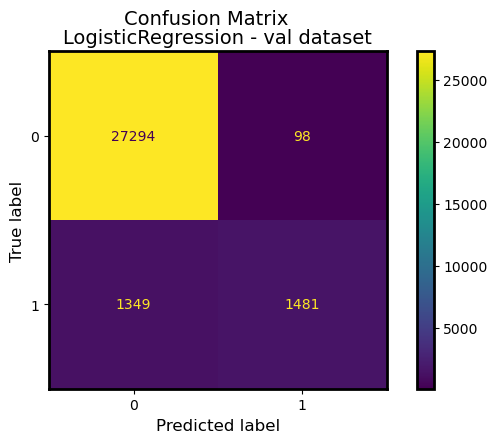



LogisticRegression - val dataset

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     27392
           1       0.94      0.52      0.67      2830

    accuracy                           0.95     30222
   macro avg       0.95      0.76      0.82     30222
weighted avg       0.95      0.95      0.95     30222



In [57]:
# Show confusion matrix and summary for Logistic Regression
mp_df.loc[0]['mp'].confusion_matrix('val')
mp_df.loc[0]['mp'].summary('val')

### Selected Model Gains Review (in business terms)

In [58]:
# Recombine predictors and target
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_val = pd.concat([X_val, y_val], axis=1)

# Iterate model ('method') results to calc fraud savings
for index, row in mp_df.iterrows():
    mp = row['mp']
    prob_col = str(index)+'_prob'
    prof_col = str(index)+'_prof'

    # Add prediction probabilities for each model ('method') to each row; these are
    #   effectively the adjusted probability of donation for each model type
    if mp.pred_proba['train'] is not None:
        Xy_train[prob_col] = mp.pred_proba['train'][:, 1]
        Xy_val[prob_col] = mp.pred_proba['val'][:, 1]
    else:
        Xy_train[prob_col] = 0.0
        Xy_val[prob_col] = 0.0

    Xy_train[prof_col] = Xy_train[prob_col] * Xy_train['purchase_value']
    Xy_val[prof_col] = Xy_val[prob_col] * Xy_val['purchase_value']

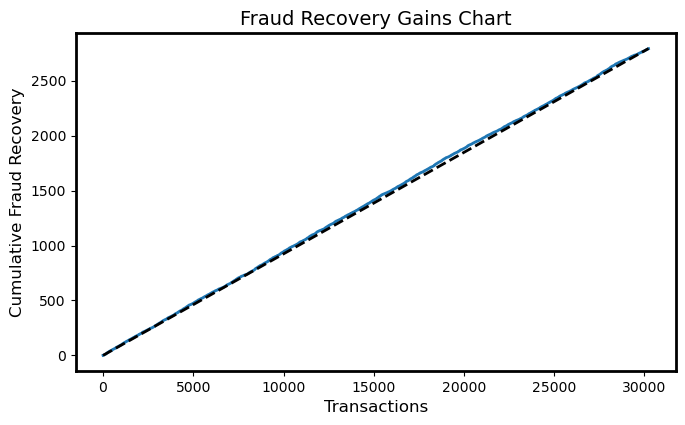

In [59]:
# Now show gains chart for Logistic Regression
fig, ax = plt.subplots()
gainsChart(pd.DataFrame(mp_df.loc[0]['mp'].pred_proba['val'][:, 1])[0], ax=ax)
ax.set_title('Fraud Recovery Gains Chart')
ax.set_xlabel('Transactions')
ax.set_ylabel('Cumulative Fraud Recovery')
plt.show()

In [60]:
# Show fraud recovery dollars for Logistic Regression
print('\nFraud recovery estimate: ${:0,.0f}'.format(sum(Xy_val['0_prof'])))
print('\nFraud recovery estimate as percentage of total: {:0,.1f}%'.\
      format(sum(Xy_val['0_prof']) / sum(Xy_val['purchase_value']) * 100.0))


Fraud recovery estimate: $103,435

Fraud recovery estimate as percentage of total: 9.3%
